# Self Organizing Map template

## ======= import the data ========

In [1]:
import pandas as pd
dataset = pd.read_csv('Credit_Card_Applications.csv')
x = dataset.iloc[:, :-1].values #should IDs be kept in the data for SOM?
y = dataset.iloc[:, -1].values #for labeling the nodes that got assigned to some input data

## ========== Feature Scaling ==========

In [2]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
x = sc.fit_transform(x)

## ======= Fitting the SOM to datat =========

In [3]:
from minisom import MiniSom
som = MiniSom(x=10, y=10, input_len=x.shape[1], sigma=1.0, learning_rate=0.5, random_seed=0)
som.random_weights_init(x)
som.train_random(data=x, num_iteration=100)

## ========= Visualizing the results =============

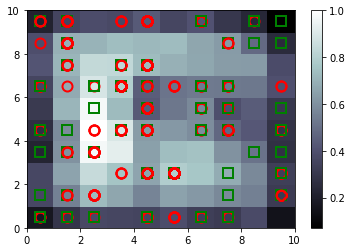

In [4]:
from pylab import bone, pcolor, colorbar, plot, show
bone()
pcolor(som.distance_map().T)
colorbar()
markers = ['o', 's']
colors = ['r', 'g']
for i, xx in enumerate(x):
    w = som.winner(xx)
    plot(w[0] + 0.5,
         w[1] + 0.5,
         markers[y[i]],
         markeredgecolor = colors[y[i]],
         markerfacecolor = 'None',
         markersize = 10,
         markeredgewidth = 2)
show() #the circles and squares indicate different types of the input data

## ======== Finding the frauds ==========

In [5]:
import numpy as np
mappings = som.win_map(x)
frauds = np.concatenate((mappings[(2, 3)], mappings[(2, 4)], mappings[(2, 5)]), axis = 0)
frauds = sc.inverse_transform(frauds)

## ====== With the frauds,  build ANN to predict the frauds =====

### ======= make training data ========

In [6]:
x_train = dataset.iloc[:, 1:].values
y_train = [0]*dataset.shape[0]

for i in range(dataset.shape[0]):
    if dataset.iloc[i, 0] in frauds:
        y_train[i] = 1
y_train = np.array(y_train)

### ========= Feature Scaling ========

In [7]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)

### ======= Construct the ANN ========

In [8]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

def build_classifier(_optimizer):
    #Initializing
    classifier = Sequential()
    
    #add the input layer and the hidden layers and output layer =====
    classifier.add(Dense(units=6, kernel_initializer='uniform', activation='relu', input_dim = x_train.shape[1])) #1st
    #classifier.add(Dropout(p=0.1)) #dealwith overfitting
    
    classifier.add(Dense(units=6, kernel_initializer='uniform', activation='relu')) #2nd
    #classifier.add(Dropout(p=0.1)) #dealwith overfitting
    
    classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid')) #output
    
    #Compiling 
    classifier.compile(optimizer=_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return classifier

Using TensorFlow backend.


### ======== Applying Grid Search to find the best model and the best parameters ========

In [9]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
classifier = KerasClassifier(build_fn=build_classifier)
parameters = [{'batch_size': [10, 20],
              'epochs': [20, 40], 
              '_optimizer': ['adam']}] #try 'rmsprop' or other values with capable machines.
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs=-1) 
grid_search = grid_search.fit(x_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print('The best accuracy:', best_accuracy)
print('The best parameters:', best_parameters)

Epoch 1/40
690/690 [==============================] - 0s 478us/step - loss: 0.6673 - acc: 0.9725
Epoch 2/40
690/690 [==============================] - 0s 214us/step - loss: 0.5241 - acc: 0.9768
Epoch 3/40
690/690 [==============================] - 0s 214us/step - loss: 0.2850 - acc: 0.9768
Epoch 4/40
690/690 [==============================] - 0s 224us/step - loss: 0.1537 - acc: 0.9768
Epoch 5/40
690/690 [==============================] - 0s 214us/step - loss: 0.1040 - acc: 0.9768
Epoch 6/40
690/690 [==============================] - 0s 212us/step - loss: 0.0851 - acc: 0.9768
Epoch 7/40
690/690 [==============================] - 0s 209us/step - loss: 0.0758 - acc: 0.9768
Epoch 8/40
690/690 [==============================] - 0s 209us/step - loss: 0.0705 - acc: 0.9768
Epoch 9/40
690/690 [==============================] - 0s 213us/step - loss: 0.0659 - acc: 0.9768
Epoch 10/40
690/690 [==============================] - 0s 206us/step - loss: 0.0626 - acc: 0.9768
Epoch 11/40
690/690 [========

### ========= Applying the K-Fold cross validation ======

In [10]:
from sklearn.model_selection import cross_val_score
classifier = KerasClassifier(build_fn = build_classifier, _optimizer = 'adam', batch_size = 10, epochs = 40)
accuracies = cross_val_score(estimator = classifier, X = x_train, y = y_train, cv = 10, n_jobs = -1)
print ('The averaged accuracy is %f, and\nstd is %f.\n'%(accuracies.mean(), accuracies.std()))

The averaged accuracy is 0.978261, and
std is 0.017452.



### ======== Visualize the loss =========

Epoch 1/40
690/690 [==============================] - 1s 728us/step - loss: 0.6677 - acc: 0.9739
Epoch 2/40
690/690 [==============================] - 0s 255us/step - loss: 0.5355 - acc: 0.9768
Epoch 3/40
690/690 [==============================] - 0s 263us/step - loss: 0.2834 - acc: 0.9768
Epoch 4/40
690/690 [==============================] - 0s 260us/step - loss: 0.1321 - acc: 0.9768
Epoch 5/40
690/690 [==============================] - 0s 252us/step - loss: 0.0924 - acc: 0.9768
Epoch 6/40
690/690 [==============================] - 0s 254us/step - loss: 0.0792 - acc: 0.9768
Epoch 7/40
690/690 [==============================] - 0s 226us/step - loss: 0.0728 - acc: 0.9768
Epoch 8/40
690/690 [==============================] - 0s 223us/step - loss: 0.0678 - acc: 0.9768
Epoch 9/40
690/690 [==============================] - 0s 218us/step - loss: 0.0637 - acc: 0.9768
Epoch 10/40
690/690 [==============================] - 0s 218us/step - loss: 0.0602 - acc: 0.9768
Epoch 11/40
690/690 [========

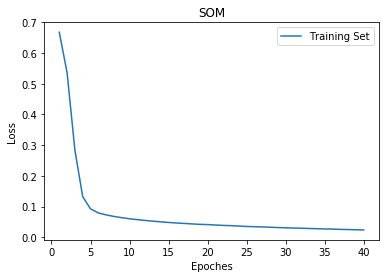

In [16]:
classifier = build_classifier('adam')
history = classifier.fit(x_train, y_train, batch_size= 10, epochs=40)

import matplotlib.pyplot as plt
num_epoches = len(history.history['loss'])
plt.plot (history.history['loss'], label = 'Training Set')
#plt.xticks(np.arange(0, 1+num_epoches), labels = [str(i+1) for i in range(num_epoches)])
plt.xticks(ticks = range(-1, 1+num_epoches, 5), labels = [str(i) for i in range(0, 1+num_epoches, 5)])
plt.title('SOM')
plt.ylabel('Loss')
plt.xlabel('Epoches')
plt.legend()
plt.show()

### ====== Predict the probability of getting frauds =======

In [17]:
classifier.fit(x_train, y_train)
y_pred_train = classifier.predict(x_train)
y_pred_train = np.append(dataset.iloc[:, 0].values.reshape((-1, 1)), y_pred_train.reshape((-1, 1)), axis=1)
y_pred_train = y_pred_train[y_pred_train[:, 1].argsort()] #sort the prediction so that easier to find the most probable frauds.

Epoch 1/1
690/690 [==============================] - 0s 118us/step - loss: 0.0233 - acc: 0.9768
